In [136]:
import pandas as pd
import numpy as np
import itertools
import matplotlib

In [120]:
out2_5000 = pd.read_csv("apriori/5000/5000-out2.csv", header=None)
out2_20000 = pd.read_csv("apriori/20000/20000-out2.csv", header=None)
out2_1000 = pd.read_csv("apriori/1000/1000-out2.csv", header=None)
i1000 = pd.read_csv("apriori/1000/1000i.csv", header=None)
out2_ex = pd.read_csv("example/out2.csv", header=None)
bingo = pd.read_csv("bingoBaskets.csv", header=None, names=range(35))
authors = pd.read_csv("https://users.csc.calpoly.edu/~dekhtyar/466-Fall2023/data/BINGO/authorlist.psv", delimiter="|", header=None)
goods = pd.read_csv("goods.csv")

In [24]:
goods.head()

,Id,Flavor,Food,Price,Type
0,0,'Chocolate','Cake',8.95,'Food'
1,1,'Lemon','Cake',8.95,'Food'
2,2,'Casino','Cake',15.95,'Food'
3,3,'Opera','Cake',15.95,'Food'
4,4,'Strawberry','Cake',11.95,'Food'


In [119]:
bingo.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0,6,13,63,70,91,178,218.0,347.0,368.0,...,1279.0,1387.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3,88,91,95,117,136,166.0,188.0,358.0,...,1271.0,1291.0,1311.0,1329.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,32,91,113,123,166,188,240.0,259.0,357.0,...,1405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,6,18,48,88,166,194,197.0,281.0,292.0,...,1314.0,1321.0,1337.0,1362.0,1377.0,1406.0,NaN,NaN,NaN,NaN
4,4,1,3,91,95,166,235,249.0,358.0,453.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
authors.tail()

,0,1
1406,1407,"de Larrabeiti, Michael"
1407,1408,"de Lint, Charles"
1408,1409,"del Toro, Guillermo"
1409,1410,uru-chan
1410,1411,"von Goethe, Johann Wolfgang"


In [125]:
bingo_onehot = pd.get_dummies(bingo)
bingo_onehot.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0,6,13,63,70,91,178,218.0,347.0,368.0,...,1279.0,1387.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3,88,91,95,117,136,166.0,188.0,358.0,...,1271.0,1291.0,1311.0,1329.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,32,91,113,123,166,188,240.0,259.0,357.0,...,1405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,6,18,48,88,166,194,197.0,281.0,292.0,...,1314.0,1321.0,1337.0,1362.0,1377.0,1406.0,NaN,NaN,NaN,NaN
4,4,1,3,91,95,166,235,249.0,358.0,453.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def genSet(num):
    s = set()
    for i in range(1,num+1):
        s.add(i)
    return s

In [58]:
def freqItems(data, items, minSup):
    freq_items = set()
    for i in items:
        if data[i].sum() / len(data.index) >= minSup:
            freq_items.add(i)
    return freq_items

In [9]:
def getSubsets(s, n):
    return list(itertools.combinations(s, n))

In [75]:
def candidateGen(F, k):
    C = set()
    f = tuple(F)
    for i in range(len(f)):
        for j in range(i+1, len(f)):
            if k == 1:
                if i != j:
                    temp = set()
                    temp.add(f[i])
                    temp.add(f[j])
                    c = tuple(temp)
                    flag = True
                    for s in c:
                        if s not in F:
                            flag = False
                    if flag == True:
                        C.add(c)
                        
            elif len(f[i]) == len(f[j]) and len(f[i]) == k:
                if len(set(f[i]).union(set(f[j]))) == len(f[i]) + 1:
                    c = tuple(set(f[i]).union(set(f[j])))
                    flag = True
                    for s in getSubsets(c, len(c)-1):
                        if s not in F:
                            flag = False
                    if flag == True:
                        C.add(c)
    return C   

In [15]:
def is_subset_binary(subset, superset):
    if len(subset) != len(superset):
        return False
    for i in range(len(subset)):
        if subset[i] == 1 and superset[i+1] == 0:
            return False
    return True

In [11]:
def convert_binary(t, l):
    lis = [0] * l
    for i in t:
        lis[i-1] = 1
    tup = tuple(lis)
    return tup

In [17]:
def skyline(itemset, freq_itemsets):
    if isinstance(itemset, int):
        for other_itemset in freq_itemsets:
            if other_itemset != itemset and itemset in other_itemset:
                return False
    
    else:
        for other_itemset in freq_itemsets:
            if other_itemset != itemset and set(itemset).issubset(set(other_itemset)):
                return False
    return True

In [84]:
def Apriori(T, I, minSup):
    F = []
    F.append(freqItems(T, I, minSup))
    k = 2
    while True:
        count = []
        C = candidateGen(F[k-2],k-1)
        for c in range(len(C)):
            count.append(0)
            
        for t in range(len(T)):
            for c in range(len(C)):
                if is_subset_binary(convert_binary(tuple(C)[c],len(T.columns)-1), T.iloc[t][1:]):
                    count[c] += 1
        F.append(set())
        
        for c in range(len(C)):
            if (count[c] / len(T)) >= minSup:
                F[k-1].add(tuple(C)[c])
                
        if not F[k-1]:
            F.pop()
            break
            
        for item in list(F[k-2]):
            if not skyline(item, F[k-1]):
                F[k-2].remove(item)
        
        k += 1
    return F

<Axes: >

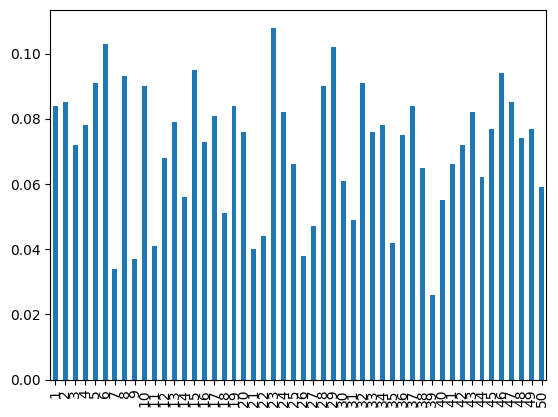

In [143]:
((out2_1000.sum()[1:])/1000).plot.bar()

In [94]:
Apriori(out2_ex, genSet(50), 0.1)

[set(), {(2, 50), (10, 23), (16, 37)}, {(17, 13, 15)}]

In [149]:
Apriori(out2_1000, genSet(50), 0.04)

[{8,
  11,
  12,
  14,
  15,
  16,
  18,
  21,
  22,
  24,
  25,
  27,
  30,
  31,
  34,
  35,
  38,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  48,
  49,
  50},
 {(1, 3),
  (1, 47),
  (2, 20),
  (6, 23),
  (10, 5),
  (17, 33),
  (19, 4),
  (19, 36),
  (28, 29),
  (32, 13),
  (32, 37),
  (37, 13)}]

In [148]:
Apriori(out2_5000, genSet(50), 0.08)

[{2, 4, 5, 6, 8, 10, 17, 19, 23, 28, 29, 33, 36, 38, 43, 46, 47}]